<a href="https://colab.research.google.com/github/stellaw1/400q-project/blob/main/400q_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setups

### Installations
We trained our models using `tensorflow-quantum`, a quantum machine learning library that builds off of the popular `tensorflow` ML framework and `Cirq` for quantum circuit designs

In [1]:
!pip install pennylane
!pip install tensorflow==2.7.0
!pip install tensorflow-quantum==0.7.2
!pip install cirq
!pip install qiskit
!pip install pygad>=2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.7/489.7 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 kB 46.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Succ

### Imports

In [67]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import itertools
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from matplotlib import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# Layer Definition

the SU4 circuit provided in the paper is also shown here for comparisons with our defined circuit:
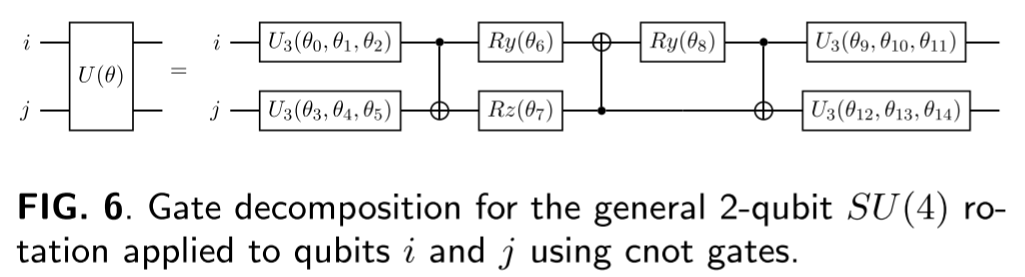

### One / Two Qubit Unitary
Basic building block of the QCNN and bQCNN defined below, this closely follows the circuit figures described in the bQCNN paper by MacCormack Et al. 

In [5]:
def one_qubit_unitary(bit, symbols):
    """
    SU(2) one qubit unitary
    """
    return cirq.Circuit(
        cirq.rx(symbols[0])(bit),
        cirq.ry(symbols[1])(bit),
        cirq.rz(symbols[2])(bit))
        # cirq.X(bit)**symbols[0],
        # cirq.Y(bit)**symbols[1],
        # cirq.Z(bit)**symbols[2])

def controlled_one_qubit_unitary(control_bit, target_bit, symbols):
    """ 
    Controlled version of the SU(2) one qubit unitary
    """
    return cirq.Circuit(
        cirq.X(target_bit).controlled_by(control_bit)**symbols[0],
        cirq.Y(target_bit).controlled_by(control_bit)**symbols[1],
        cirq.Z(target_bit).controlled_by(control_bit)**symbols[2])

def two_qubit_unitary(bits, symbols):
    """
    SU(4) two qubit unitary as described in Figure 6 of the bQCNN paper
    """
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [
      cirq.CNOT(bits[0], bits[1]),
      cirq.Ry(rads=symbols[6])(bits[0]), 
      cirq.Rz(rads=symbols[7])(bits[1]), 
      cirq.CNOT(bits[1], bits[0]),
      cirq.Ry(rads=symbols[8])(bits[0]),
      cirq.CNOT(bits[0], bits[1]),
    ]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit

defined circuits drawn using `SVGCircuit` library

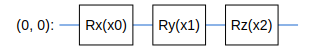

In [6]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))

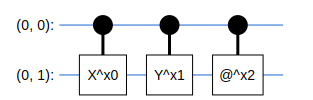

In [7]:
SVGCircuit(controlled_one_qubit_unitary(cirq.GridQubit.rect(1, 2)[0], cirq.GridQubit.rect(1, 2)[1], sympy.symbols('x0:3')))

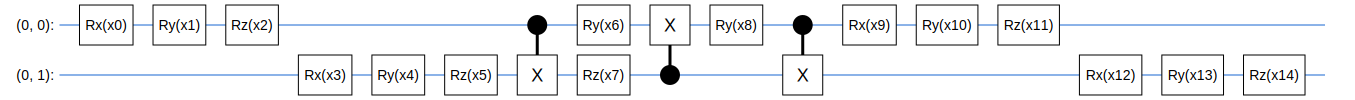

In [8]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

### Z feature map

In [9]:
def Z_feature_map(qubits, params):
    """
    4-qubit Z feature map mimicing qiskit's Z feature map
    """
    circuit = cirq.Circuit()
    for i in range(len(qubits)):
        circuit += cirq.H(qubits[i])
        circuit += cirq.rz(float(params[i]))(qubits[i])
        circuit += cirq.H(qubits[i])
        circuit += cirq.rz(float(params[i]))(qubits[i])
    return circuit

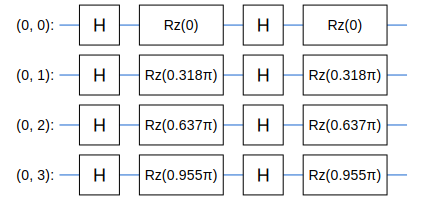

In [10]:
SVGCircuit(Z_feature_map(cirq.GridQubit.rect(1, 4), list(range(15))))

### Convolution Layers

Definition for the quantum convolution, pooling, and **branching** layers

In [11]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the figures and definition provided
    by the bQCNN paper.
    Returns a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for i in range(1,len(bits)):
        circuit += two_qubit_unitary([bits[i-1], bits[i]], symbols[(i-1)*15:i*15])
    return circuit

The basic convolution layer entangles qubits next to each other using the `two_qubit_unitary` gate defined earlier

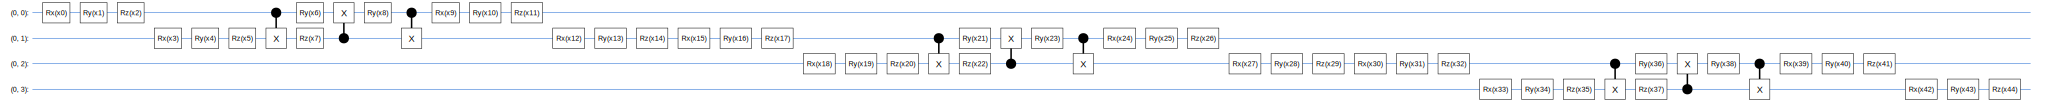

In [12]:
SVGCircuit(
    quantum_conv_circuit(cirq.GridQubit.rect(1, 4), sympy.symbols('x0:45')))

In [13]:
def quantum_branch_pool_circuit(qubits, symbols):
  """ 'pooling' layer of the 4-Qbit bQCNN: controlled one qubit unitary applied
  to qubits right before measurement
  """
  circuit = cirq.Circuit()
  L = len(qubits)
  for i in range(L // 2):
    circuit += controlled_one_qubit_unitary(qubits[i], qubits[i + L // 2], symbols[3*i:3*(i+1)])
  return circuit

The pooling layer is simply a controlled version of the `one_qubit_unitary` circuit defined earlier. The control wires are the wires that are being pooled away (i.e. measured) and the target wires are applied the rotations 

Below circuit will measure qubits 0 and 1 and keep qubits 2 and 3

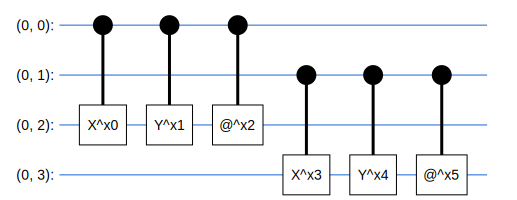

In [14]:
test_bits = cirq.GridQubit.rect(1,4)

SVGCircuit(
    quantum_branch_pool_circuit(test_bits, sympy.symbols('x0:111')))

The quantum **branching** layer containing distinct layers of quantum convolution layers where the choice of which branch to enter is decided by the measurement outcome of the measurement qubits.

This is achieved by applying controls based on the measurement outcomes of the measurement wires. For 4 qubits, the lower 2 qubits are the measurement qubits and their outcome controls which of the 4 branches the upper 2 qubits enter. 

In [15]:
def quantum_branch_conv_circuit(qubits, symbols):
    """ branching layer of the 4-Qbit bQCNN: 
    conditional gates are applied depending on the measurement outcome
    of the discarded qubits
    """
    L = len(qubits)

    circuit = cirq.Circuit()

    # Measure 2L/3 of the input qubits
    measurement_qubits = qubits[:2*L//3]
    measurement_ops = [cirq.measure(qubit, key=f'm{idx}') for idx, qubit in enumerate(measurement_qubits)]

    circuit += measurement_ops

    # Create 2^(2L/3) branches for the remaining L/3 qubits
    remaining_qubits = qubits[2*L//3:]
    branch_permutations = list(itertools.product([0, 1], repeat=2*L//3))

    for branch in range(2 ** (2 * L // 3)): # total 2 ^ (2 * L // 3) branches
        # Apply two_qubit_unitary to the 2 remaining qubits in each branch
        branch_symbols = symbols[branch * 15:(branch + 1) * 15]
        branch_unitary = two_qubit_unitary(remaining_qubits, branch_symbols)
        
        # Create a controlled_gate and add it to the circuit
        for moment in branch_unitary:
            for op in moment:
              controlled_gate = cirq.ControlledGate(op.gate, num_controls=len(measurement_qubits), control_values=branch_permutations[branch])
              circuit.append(controlled_gate(*measurement_qubits, *op.qubits))

    return circuit

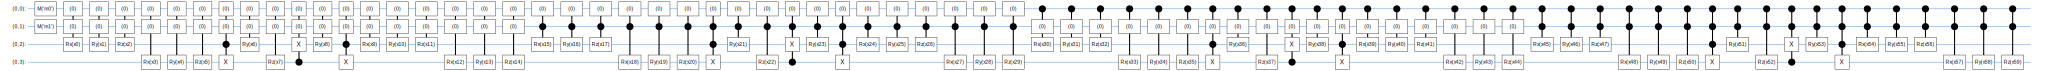

In [16]:
test_bits = cirq.GridQubit.rect(1, 4)

SVGCircuit(
    quantum_branch_conv_circuit(test_bits, sympy.symbols('x0:60')))

In [17]:
def create_qcnn_circuit(qubits):
    """creates a qcnn circuit"""
    circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:66')
    circuit += quantum_conv_circuit(qubits, symbols[0:45])
    circuit += quantum_branch_pool_circuit(qubits, symbols[45:51])
    circuit += quantum_conv_circuit(qubits[2:], symbols[51:66])
    return circuit

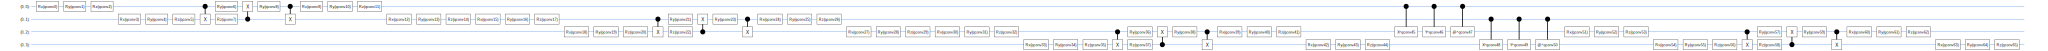

In [18]:

test_bits = cirq.GridQubit.rect(1, 4)

SVGCircuit(
    create_qcnn_circuit(test_bits))

In [19]:
def create_bqcnn_circuit(qubits):
    """creates a bqcnn circuit"""
    circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:117')
    circuit += quantum_conv_circuit(qubits, symbols[0:45]) # 3 * 15 
    circuit += quantum_branch_pool_circuit(qubits, symbols[45:51]) # 2 * 3
    circuit += quantum_branch_conv_circuit(qubits, symbols[51:111]) # 4 * 15
    circuit += quantum_branch_pool_circuit(qubits, symbols[111:117]) # 2 * 3
    return circuit

In [20]:
test_bits = cirq.GridQubit.rect(1, 4)

SVGCircuit(
    create_bqcnn_circuit(test_bits))

# Data

### Randomized Excitations to cluster state

Generate PauliX ops with a random theta [-pi, pi] on a random wires, both the ```generate_data``` and the ```cluster_state``` function is taken from the TensorFlow Quantum QCNN tutorial https://www.tensorflow.org/quantum/tutorials/qcnn

In [21]:
def generate_data(qubits, n_rounds=50):
    """Generate training and testing data."""
    # Produces n_rounds * n_qubits datapoints.
    train_excitations = []
    test_excitations = []
    train_labels = []
    test_labels = []

    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            train_excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            train_labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else 0.0)

    for n in range(n_rounds // 2):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            test_excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            test_labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else 0.0)

    return tfq.convert_to_tensor(train_excitations), np.array(train_labels), tfq.convert_to_tensor(test_excitations), np.array(test_labels)

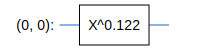

In [22]:
train_excitations, _, _, _ = generate_data(cirq.GridQubit.rect(1,4), 1)

SVGCircuit(tfq.from_tensor(train_excitations)[0])

In [23]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

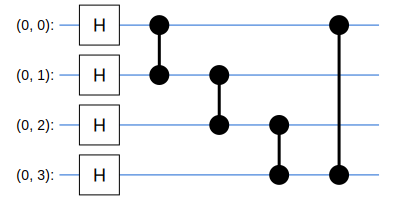

In [24]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(1,4)))

### Random 4-pixel images

Generate random 4 pixel images containing either a horizontal line or vertical line

In [109]:
''' 
4 pixel image generation code referenced from: 
https://qiskit.org/ecosystem/machine-learning/tutorials/11_quantum_convolutional_neural_networks.html
'''
def generate_4pixel_images(qubits, n_rounds=40):
    images = []
    data = []
    labels = []
    hor_array = np.zeros((2, 4))
    ver_array = np.zeros((2, 4))

    j = 0
    for i in range(0, 3):
        if i != 1:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 2):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 2] = np.pi / 2
        j += 1

    for n in range(n_rounds):
        rng = np.random.randint(0, 2)
        if rng == 0:
            labels.append(0)
            random_image = np.random.randint(0, 2)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = np.random.randint(0, 2)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(4):
            if images[-1][i] == 0:
                images[-1][i] = np.random.random()

    for image in images:
        data.append(cirq.Circuit(Z_feature_map(qubits, image)))

    train_images, test_images, train_labels, test_labels = train_test_split(
        data, labels, test_size=0.3
    )

    return tfq.convert_to_tensor(train_images), np.array(train_labels), tfq.convert_to_tensor(test_images), np.array(test_labels), images

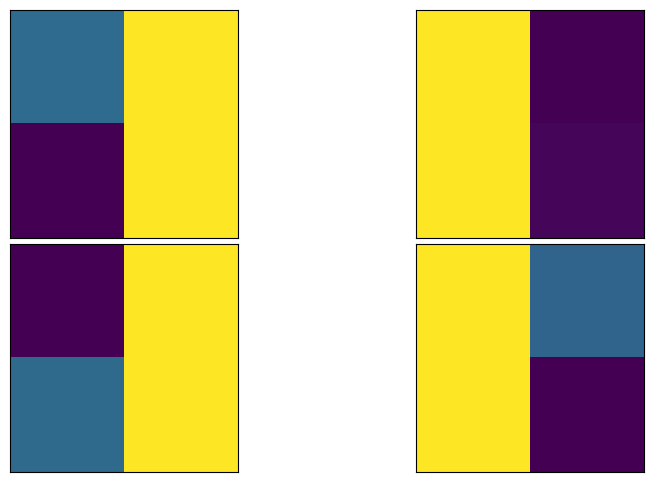

In [110]:
_, _, _, _, images = generate_4pixel_images(cirq.GridQubit.rect(1,4))

fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        images[i].reshape(2, 2),
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

# Training

## Randomly Generated Excitations

### Defining Models

In [167]:
# input bits
input_bits = cirq.GridQubit.rect(1, 4)

# declare the quantum neural network layers using tensorflow quantum Parameterized Quantum Circuit (PQC)

# bQCNN mse
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(excitation_input, prepend=cluster_state_circuit(input_bits))
bqcnn_quantum_model = tfq.layers.PQC(create_bqcnn_circuit(input_bits), cirq.Z(input_bits[-1]))(cluster_state)
bqcnn_model_mse = tf.keras.Model(inputs=[excitation_input], outputs=[bqcnn_quantum_model])

# bQCNN mae
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(excitation_input, prepend=cluster_state_circuit(input_bits))
bqcnn_quantum_model = tfq.layers.PQC(create_bqcnn_circuit(input_bits), cirq.Z(input_bits[-1]))(cluster_state)
bqcnn_model_mae = tf.keras.Model(inputs=[excitation_input], outputs=[bqcnn_quantum_model])

# QCNN mse
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(excitation_input, prepend=cluster_state_circuit(input_bits))
qcnn_quantum_model = tfq.layers.PQC(create_qcnn_circuit(input_bits), cirq.Z(input_bits[-1]))(cluster_state)
qcnn_model_mse = tf.keras.Model(inputs=[excitation_input], outputs=[qcnn_quantum_model])

# QCNN mae
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(excitation_input, prepend=cluster_state_circuit(input_bits))
qcnn_quantum_model = tfq.layers.PQC(create_qcnn_circuit(input_bits), cirq.Z(input_bits[-1]))(cluster_state)
qcnn_model_mae = tf.keras.Model(inputs=[excitation_input], outputs=[qcnn_quantum_model])

Generate Data

In [168]:
train_excitations, train_labels, test_excitations, test_labels = generate_data(cirq.GridQubit.rect(1, 4))

Define Hyperparameters

In [169]:
learning_rate = 0.002
batch_size = 16 # >= 1
epochs = 25
verbose = 0 # 0: not verbose, 1: verbose

### Training bQCNN with MSE loss


In [170]:
bqcnn_model_mse.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                   loss=tf.losses.mse,
                   metrics=[])

bqcnn_history_mse = bqcnn_model_mse.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=verbose,
                         validation_data=(test_excitations, test_labels))


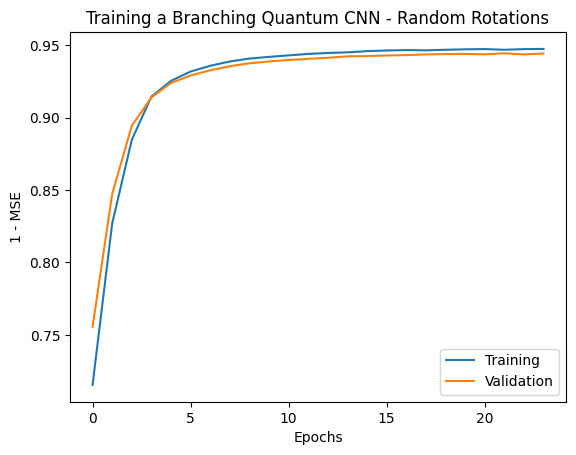

In [171]:
plt.plot(1-np.array(bqcnn_history_mse.history['loss'][1:]), label='Training')
plt.plot(1-np.array(bqcnn_history_mse.history['val_loss'][1:]), label='Validation')
plt.title('Training a Branching Quantum CNN - Random Rotations')
plt.xlabel('Epochs')
plt.ylabel('1 - MSE')
plt.legend()
plt.show()

### Training bQCNN with MAE loss


In [172]:
bqcnn_model_mae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                   loss=tf.losses.mae,
                   metrics=[])

bqcnn_history_mae = bqcnn_model_mae.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=verbose,
                         validation_data=(test_excitations, test_labels))

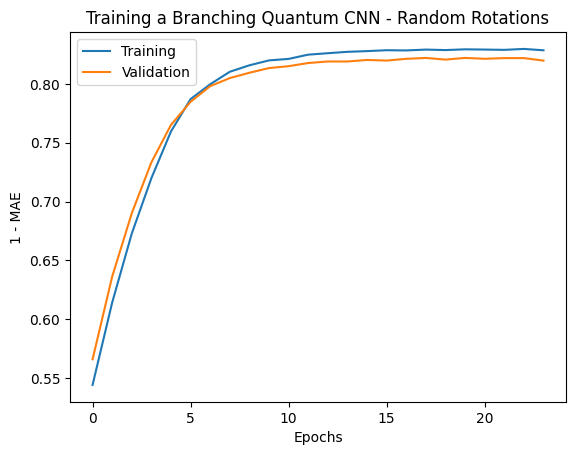

In [173]:
plt.plot(1-np.array(bqcnn_history_mae.history['loss'][1:]), label='Training')
plt.plot(1-np.array(bqcnn_history_mae.history['val_loss'][1:]), label='Validation')
plt.title('Training a Branching Quantum CNN - Random Rotations')
plt.xlabel('Epochs')
plt.ylabel('1 - MAE')
plt.legend()
plt.show()

### Training QCNN with MSE loss

In [174]:
qcnn_model_mse.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                   loss=tf.losses.mse,
                   metrics=[])

qcnn_history_mse = qcnn_model_mse.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=verbose,
                         validation_data=(test_excitations, test_labels))

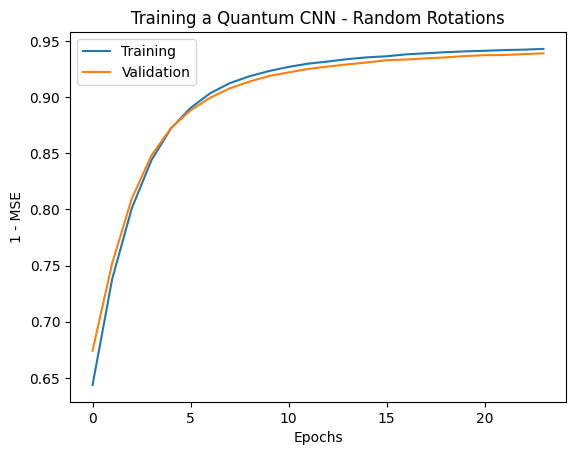

In [175]:
plt.plot(1-np.array(qcnn_history_mse.history['loss'][1:]), label='Training')
plt.plot(1-np.array(qcnn_history_mse.history['val_loss'][1:]), label='Validation')
plt.title('Training a Quantum CNN - Random Rotations')
plt.xlabel('Epochs')
plt.ylabel('1 - MSE')
plt.legend()
plt.show()

### Training QCNN with MAE loss

In [176]:
qcnn_model_mae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                   loss=tf.losses.mae,
                   metrics=[])

qcnn_history_mae = qcnn_model_mae.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=verbose,
                         validation_data=(test_excitations, test_labels))

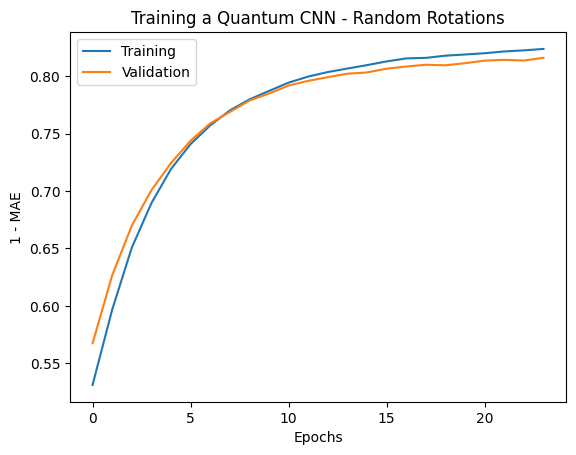

In [177]:
plt.plot(1-np.array(qcnn_history_mae.history['loss'][1:]), label='Training')
plt.plot(1-np.array(qcnn_history_mae.history['val_loss'][1:]), label='Validation')
plt.title('Training a Quantum CNN - Random Rotations')
plt.xlabel('Epochs')
plt.ylabel('1 - MAE')
plt.legend()
plt.show()

### Comparisons

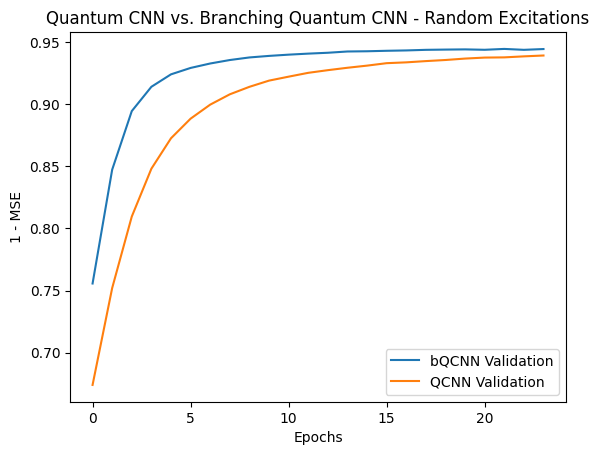

In [178]:
plt.plot(1-np.array(bqcnn_history_mse.history['val_loss'][1:]), label='bQCNN Validation')
plt.plot(1-np.array(qcnn_history_mse.history['val_loss'][1:]), label='QCNN Validation')
plt.title('Quantum CNN vs. Branching Quantum CNN - Random Excitations')
plt.xlabel('Epochs')
plt.ylabel('1 - MSE')
plt.legend()
plt.show()

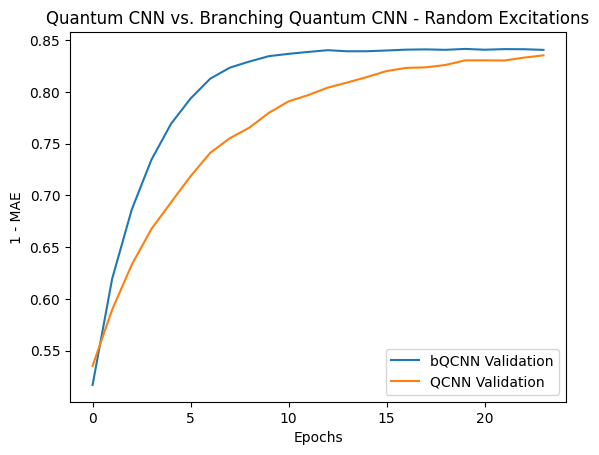

In [66]:
plt.plot(1-np.array(bqcnn_history_mae.history['val_loss'][1:]), label='bQCNN Validation')
plt.plot(1-np.array(qcnn_history_mae.history['val_loss'][1:]), label='QCNN Validation')
plt.title('Quantum CNN vs. Branching Quantum CNN - Random Excitations')
plt.xlabel('Epochs')
plt.ylabel('1 - MAE')
plt.legend()
plt.show()

## 4-pixel images

### Defining Models

In [154]:
# input bits
input_bits = cirq.GridQubit.rect(1, 4)

# declare the quantum neural network layers using tensorflow quantum Parameterized Quantum Circuit (PQC)

# bQCNN mse
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
bqcnn_quantum_model = tfq.layers.PQC(create_bqcnn_circuit(input_bits), cirq.Z(input_bits[-1]))(excitation_input)
bqcnn_model_mse = tf.keras.Model(inputs=[excitation_input], outputs=[bqcnn_quantum_model])

# bQCNN mae
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
bqcnn_quantum_model = tfq.layers.PQC(create_bqcnn_circuit(input_bits), cirq.Z(input_bits[-1]))(excitation_input)
bqcnn_model_mae = tf.keras.Model(inputs=[excitation_input], outputs=[bqcnn_quantum_model])

# QCNN mse
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
qcnn_quantum_model = tfq.layers.PQC(create_qcnn_circuit(input_bits), cirq.Z(input_bits[-1]))(excitation_input)
qcnn_model_mse = tf.keras.Model(inputs=[excitation_input], outputs=[qcnn_quantum_model])

# QCNN mae
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
qcnn_quantum_model = tfq.layers.PQC(create_qcnn_circuit(input_bits), cirq.Z(input_bits[-1]))(excitation_input)
qcnn_model_mae = tf.keras.Model(inputs=[excitation_input], outputs=[qcnn_quantum_model])

Generate images

In [155]:
train_images, train_labels, test_images, test_labels, _ = generate_4pixel_images(cirq.GridQubit.rect(1,4), 100)

Define Hyperparameters

In [156]:
learning_rate = 0.005
batch_size = 16 # >= 1
epochs = 50
verbose = 0 # 0: not verbose, 1: verbose

### Training bQCNN with MSE loss


In [157]:
bqcnn_model_mse.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                   loss=tf.losses.mse,
                   metrics=[])

bqcnn_history_mse = bqcnn_model_mse.fit(x=train_images,
                         y=train_labels,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=verbose,
                         validation_data=(test_images, test_labels))

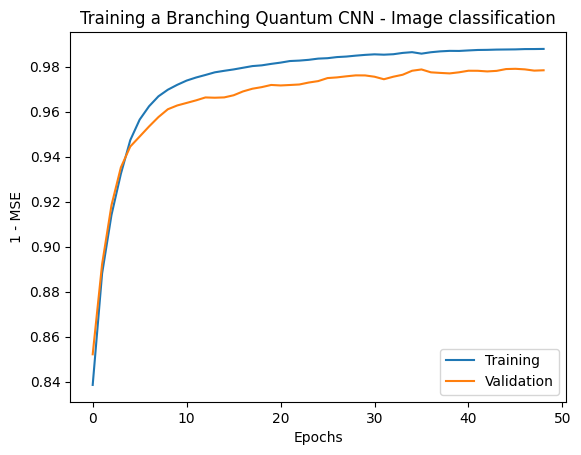

In [158]:
plt.plot(1-np.array(bqcnn_history_mse.history['loss'][1:]), label='Training')
plt.plot(1-np.array(bqcnn_history_mse.history['val_loss'][1:]), label='Validation')
plt.title('Training a Branching Quantum CNN - Image classification')
plt.xlabel('Epochs')
plt.ylabel('1 - MSE')
plt.legend()
plt.show()

### Training bQCNN with MAE loss

In [159]:
bqcnn_model_mae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                   loss=tf.losses.mae,
                   metrics=[])

bqcnn_history_mae = bqcnn_model_mae.fit(x=train_images,
                         y=train_labels,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=verbose,
                         validation_data=(test_images, test_labels))

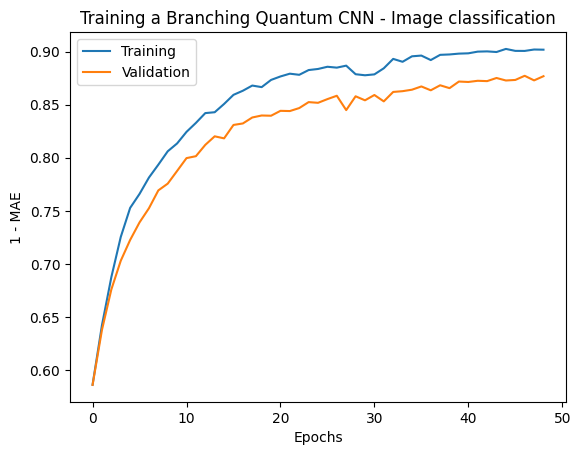

In [160]:
plt.plot(1-np.array(bqcnn_history_mae.history['loss'][1:]), label='Training')
plt.plot(1-np.array(bqcnn_history_mae.history['val_loss'][1:]), label='Validation')
plt.title('Training a Branching Quantum CNN - Image classification')
plt.xlabel('Epochs')
plt.ylabel('1 - MAE')
plt.legend()
plt.show()

### Training QCNN with MSE loss

In [161]:
qcnn_model_mse.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                   loss=tf.losses.mse,
                   metrics=[])

qcnn_history_mse = qcnn_model_mse.fit(x=train_images,
                         y=train_labels,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=verbose,
                         validation_data=(test_images, test_labels))

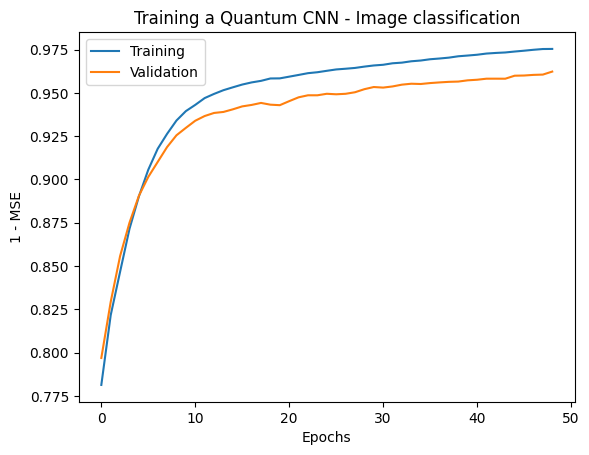

In [162]:
plt.plot(1-np.array(qcnn_history_mse.history['loss'][1:]), label='Training')
plt.plot(1-np.array(qcnn_history_mse.history['val_loss'][1:]), label='Validation')
plt.title('Training a Quantum CNN - Image classification')
plt.xlabel('Epochs')
plt.ylabel('1 - MSE')
plt.legend()
plt.show()

### Training QCNN with MAE loss

In [163]:
qcnn_model_mae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                   loss=tf.losses.mae,
                   metrics=[])

qcnn_history_mae = qcnn_model_mae.fit(x=train_images,
                         y=train_labels,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=verbose,
                         validation_data=(test_images, test_labels))

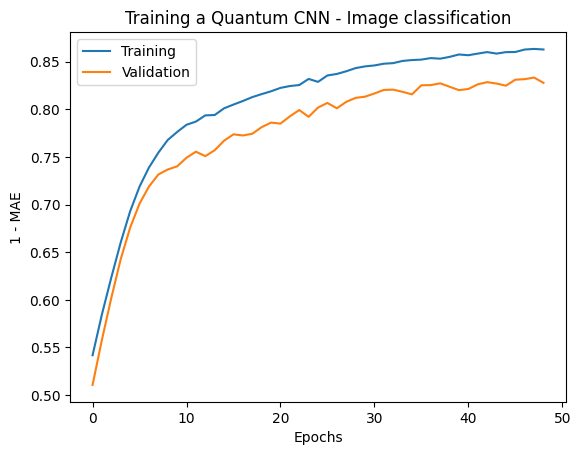

In [164]:
plt.plot(1-np.array(qcnn_history_mae.history['loss'][1:]), label='Training')
plt.plot(1-np.array(qcnn_history_mae.history['val_loss'][1:]), label='Validation')
plt.title('Training a Quantum CNN - Image classification')
plt.xlabel('Epochs')
plt.ylabel('1 - MAE')
plt.legend()
plt.show()

### Comparisons

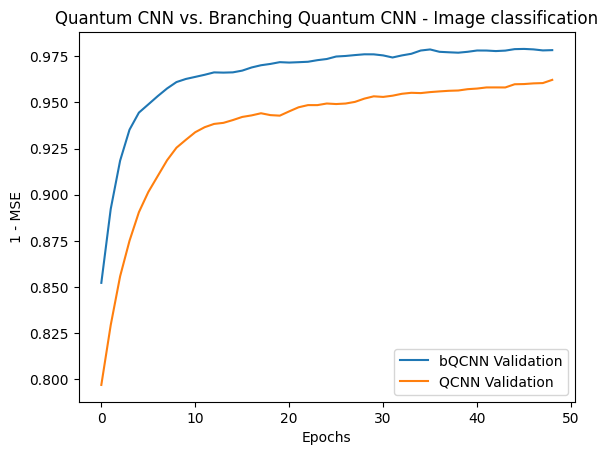

In [165]:
plt.plot(1-np.array(bqcnn_history_mse.history['val_loss'][1:]), label='bQCNN Validation')
plt.plot(1-np.array(qcnn_history_mse.history['val_loss'][1:]), label='QCNN Validation')
plt.title('Quantum CNN vs. Branching Quantum CNN - Image classification')
plt.xlabel('Epochs')
plt.ylabel('1 - MSE')
plt.legend()
plt.show()

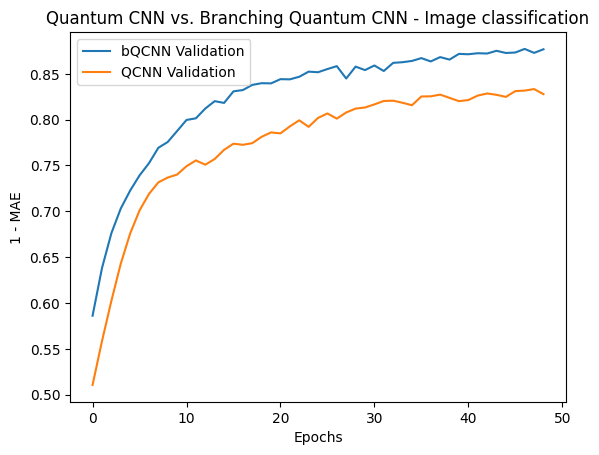

In [166]:
plt.plot(1-np.array(bqcnn_history_mae.history['val_loss'][1:]), label='bQCNN Validation')
plt.plot(1-np.array(qcnn_history_mae.history['val_loss'][1:]), label='QCNN Validation')
plt.title('Quantum CNN vs. Branching Quantum CNN - Image classification')
plt.xlabel('Epochs')
plt.ylabel('1 - MAE')
plt.legend()
plt.show()

# Expressibility

## KL Divergence

In [ ]:
# KL divergence for randomized excitations to cluster state for bQCNN circuit
bqcnn_pred = bqcnn_model_mse.predict(x=test_excitations)
bqcnn_pred = [1.0 if x > 0.5 else 0.0 for x in bqcnn_pred]

print(np.array([x for x in zip(bqcnn_pred, test_labels)]))

kl = tf.keras.losses.KLDivergence()
kl(test_labels, bqcnn_pred).numpy()


# KL divergence for randomized excitations to cluster state for QCNN circuit
qcnn_pred = qcnn_model_mse.predict(x=test_excitations)
qcnn_pred = [1.0 if x > 0.5 else 0.0 for x in qcnn_pred]

print(np.array([x for x in zip(qcnn_pred, test_labels)]))

kl = tf.keras.losses.KLDivergence()
kl(test_labels, qcnn_pred).numpy()

# Misc.

### Reversing bQCNN

In [ ]:
def create_inverse_qcnn_circuit(qubits, params):
    """creates a inversed qcnn circuit"""
    model_circuit = cirq.Circuit()
    model_circuit += cirq.inverse(quantum_conv_circuit(qubits[2:], params[51:66]))
    model_circuit += cirq.inverse(quantum_branch_pool_circuit(qubits, params[45:51]))
    model_circuit += cirq.inverse(quantum_conv_circuit(qubits, params[0:45]))
    return model_circuit

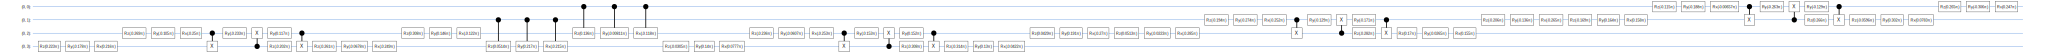

In [ ]:
test_bits = cirq.GridQubit.rect(1, 4)
SVGCircuit(create_inverse_qcnn_circuit(test_bits, 
        np.random.uniform(-1, 1, (66,))))

In [ ]:
# Function to generate all binary states for a given number of qubits
def generate_binary_states(num_qubits):
    states = []
    for i in range(2 ** num_qubits):
        binary_state = format(i, f'0{num_qubits}b')
        states.append(binary_state)
    return states

# Prepare a quantum circuit for the given state
def prepare_state(state, qubits):
    circuit = cirq.Circuit()
    for i, qubit_state in enumerate(state):
        if qubit_state == '1':
            circuit.append(cirq.X(qubits[i]))
    return circuit

# Function to simulate the circuit and measure the output
def measure_circuit(circuit, qubits, num_shots=1000):
    # Add measurement operations
    circuit.append(cirq.measure(*qubits, key='result'))

    # Simulate the circuit
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=num_shots)

    # Get the measurement results
    counts = result.histogram(key='result')
    return counts


def generate_inverse_qcnn_data(train_test_split=0.7):
    num_qubits = 4 # should be 4

    # Generate all 16 binary states for a 4-qubit circuit
    states = generate_binary_states(num_qubits)
    qubits = cirq.GridQubit.rect(1,num_qubits)

    input = []
    labels = []
    random_params = np.random.uniform(-np.pi, np.pi, (66,))

    # Measure the output of the circuit for each input state
    for state in states:
        circuit = prepare_state(state, qubits)
        print(circuit)
        circuit += create_inverse_qcnn_circuit(test_bits, random_params)
        # print(circuit)
        tensor = tfq.convert_to_tensor([circuit])
        
        input.append(circuit)
        labels.append(-1 if state[0] == 0 else 1)

    split_ind = int(len(input) * train_test_split)
    train_data = input[:split_ind]
    test_data = input[split_ind:]

    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]

    print(input)

    return tfq.convert_to_tensor(train_data), np.array(train_labels), tfq.convert_to_tensor(test_data), np.array(test_labels)


train_inputs, train_labels, test_inputs, test_labels = generate_inverse_qcnn_data()


NameError: ignored

# References